In [14]:
import pickle
import numpy as np
import xarray as xr
import netCDF4 as nc
import epicc_config as cfg
import pandas as pd
import matplotlib.pyplot as plt
import wrf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from glob import glob

In [15]:
def map_bounds(reg):

    if reg=='EPICC':
        mbounds = None
    else:
        mbounds = wrf.GeoBounds(wrf.CoordPair(lat=cfg.reg_coords[reg][0], lon=cfg.reg_coords[reg][1]),
                               wrf.CoordPair(lat=cfg.reg_coords[reg][2], lon=cfg.reg_coords[reg][3]))
    return mbounds

def customize_plots():

    mpl.style.use('seaborn-paper')

    mpl.rcParams['font.size']=16
    mpl.rcParams['font.weight']='demibold'

    mpl.rcParams['axes.spines.left']=True
    mpl.rcParams['axes.spines.bottom']=True
    mpl.rcParams['axes.spines.right']=False
    mpl.rcParams['axes.spines.top']=False
    #mpl.rcParams['font.family'] = 'sans-serif'
    #mpl.rcParams['font.sans-serif'] = 'Tahoma'

def adjust_spines2(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([])

In [16]:
# import numpy as np
# import matplotlib.pyplot as plt

# def distance(data):
#     return np.sum((data[1:] - data[:-1]) ** 2, axis=1) ** .5

# def draw_path(path):
#     HEAD_WIDTH = 2
#     HEAD_LEN = 3

#     fig = plt.figure()
#     axes = fig.add_subplot(111)

#     x = path[:,0]
#     y = path[:,1]
#     axes.plot(x, y)

#     theta = np.arctan2(y[1:] - y[:-1], x[1:] - x[:-1])
#     dist = distance(path) - HEAD_LEN

#     x = x[:-1]
#     y = y[:-1]
#     ax = x + dist * np.sin(theta)
#     ay = y + dist * np.cos(theta)

#     for x1, y1, x2, y2 in zip(x,y,ax-x,ay-y):
#         axes.arrow(x1, y1, x2, y2, head_width=HEAD_WIDTH, head_length=HEAD_LEN)
#     plt.show()

In [17]:
wrf_runs = cfg.wrf_runs
lsmooth = 50000 #Smoothing filter length in meters
dx = 2000 #Resolution of imput data
lsmooth_ngrid = np.ceil(lsmooth/dx)
pr_threshold_mmhr = 2.5 #Precipitation threshold in mm/h
freq = '01H'

mmh_factor = {'10MIN': 6.,
              '01H'  : 1.,
              'DAY'  : 1/24.}

freq_dt = {'10MIN': 600,
          '01H'  : 3600,
          'DAY'  : 86400.}

pr_threshold = pr_threshold_mmhr/mmh_factor[freq]
dt = freq_dt[freq] #Step between model outputs in seconds
wrun = wrf_runs[0]
reg = 'WME'

In [18]:
#Loading geo info from WRF
geofile_ref = nc.Dataset(f'{cfg.geofile_ref}')
xbounds = wrf.cartopy_xlim(wrfin=geofile_ref)
ybounds = wrf.cartopy_ylim(wrfin=geofile_ref)
geo_proj = wrf.get_cartopy(wrfin=geofile_ref)


hgt = wrf.getvar(geofile_ref, "ter")
lats, lons = wrf.latlon_coords(hgt)

mbounds = map_bounds(reg)



In [19]:
filesin = sorted(glob(f"{cfg.path_in}/{wrun_fut}/MCS_201509"))
datalist = []
new_storm_id = 1
for fin in filesin:
    with open(fin, 'rb') as f:
        allstorms = pickle.load(f)
        
    for storm_id in allstorms.keys():
        this_storm = allstorms[storm_id]


        for nstep in range(len(this_storm['times'])):

            if nstep == 0: 
                speed = 0
            else:
                speed = this_storm['speed'][nstep-1]
                
            datalist.append([new_storm_id,
                             nstep,
                             this_storm['times'][nstep],
                             this_storm['size'][nstep],
                             this_storm['tot'][nstep],
                             this_storm['max'][nstep],
                             this_storm['mean'][nstep],
                             speed,
                             len(this_storm['times']),
                             this_storm['track'][nstep,1],
                             this_storm['track'][nstep,0]
                            ])
            
        new_storm_id+=1
storms = pd.DataFrame(datalist, columns=['storm_id', 'nstep','datetime',
                                         'size','prvol','prmax','prmean','speed','duration','lon','lat'])#,'p80','p85','p90','p95','p99',
                                         #'hit_end','hit_border'])
    

In [20]:
wrun_fut = wrf_runs[1]
filesin = sorted(glob(f"{cfg.path_in}/{wrun_fut}/MCS_201509"))
datalist = []
new_storm_id = 1
for fin in filesin:
    with open(fin, 'rb') as f:
        allstorms = pickle.load(f)
        
    for storm_id in allstorms.keys():
        this_storm = allstorms[storm_id]


        for nstep in range(len(this_storm['times'])):

            if nstep == 0: 
                speed = 0
            else:
                speed = this_storm['speed'][nstep-1]
                
            datalist.append([new_storm_id,
                             nstep,
                             this_storm['times'][nstep],
                             this_storm['size'][nstep],
                             this_storm['tot'][nstep],
                             this_storm['max'][nstep],
                             this_storm['mean'][nstep],
                             speed,
                             len(this_storm['times']),
                             this_storm['track'][nstep,1],
                             this_storm['track'][nstep,0]
                            ])
            
        new_storm_id+=1
storms_fut = pd.DataFrame(datalist, columns=['storm_id', 'nstep','datetime',
                                         'size','prvol','prmax','prmean','speed','duration','lon','lat'])#,'p80','p85','p90','p95','p99',
                                         #'hit_end','hit_border'])
    
        
    

In [21]:
storms = storms.loc[(storms.lon>cfg.reg_coords[reg][1]) & (storms.lon<cfg.reg_coords[reg][3]) & (storms.lat>cfg.reg_coords[reg][0]) & (storms.lat<cfg.reg_coords[reg][2])]
storms['storm_id']=pd.factorize(storms.storm_id)[0] + 1

In [22]:
storms_fut = storms_fut.loc[(storms_fut.lon>cfg.reg_coords[reg][1]) & (storms_fut.lon<cfg.reg_coords[reg][3]) & (storms_fut.lat>cfg.reg_coords[reg][0]) & (storms_fut.lat<cfg.reg_coords[reg][2])]
storms_fut['storm_id']=pd.factorize(storms_fut.storm_id)[0] + 1


/home/dargueso/anaconda3/envs/e3_epicc_env/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/dargueso/anaconda3/envs/e3_epicc_env/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/dargueso/anaconda3/envs/e3_epicc_env/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/dargues

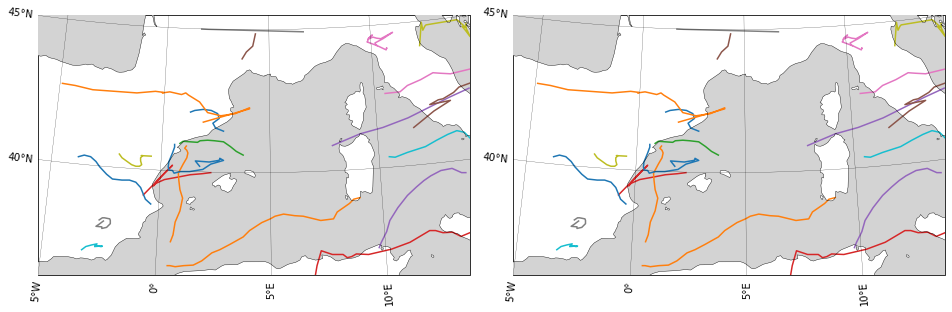

In [25]:
fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(1,2,1,projection=geo_proj)
oce10m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m')
lakes10m = cfeature.NaturalEarthFeature('physical', 'lakes', '50m')
ax.add_feature(oce10m , zorder=100,facecolor='lightgray')#facecolor=[24/255,  116/255,  205/255])
ax.add_feature(lakes10m, zorder=100,linewidth=0.5,edgecolor='k',facecolor='lightgray')
               #facecolor=[24/255,  116/255,  205/255])
ax.coastlines(linewidth=0.4,zorder=103,resolution='50m')
gl=ax.gridlines(crs=ccrs.PlateCarree(), xlocs=range(-25,35,5), ylocs=range(20,60,5),x_inline=False, y_inline=False,
                draw_labels=True, zorder=103,linewidth=0.2, color='k', alpha=1, linestyle='-')

for nstorm in storms['storm_id'].unique():
    plt.plot(storms.loc[storms['storm_id'] == nstorm].lon, 
             storms.loc[storms['storm_id'] == nstorm].lat,
             transform=ccrs.PlateCarree(),zorder=101)
gl.top_labels = False
gl.right_labels = False
ax.set_xlim(xbounds)
ax.set_ylim(ybounds)
if reg !='EPICC':
    ax.set_xlim(wrf.cartopy_xlim(hgt,geobounds=mbounds))
    ax.set_ylim(wrf.cartopy_ylim(hgt,geobounds=mbounds))
    
#FUT
ax2 = fig.add_subplot(1,2,2,projection=geo_proj)

ax2.add_feature(oce10m , zorder=100,facecolor='lightgray')#facecolor=[24/255,  116/255,  205/255])
ax2.add_feature(lakes10m, zorder=100,linewidth=0.5,edgecolor='k',facecolor='lightgray')
               #facecolor=[24/255,  116/255,  205/255])
ax2.coastlines(linewidth=0.4,zorder=103,resolution='50m')
gl2=ax2.gridlines(crs=ccrs.PlateCarree(), xlocs=range(-25,35,5), ylocs=range(20,60,5),x_inline=False, y_inline=False,
                draw_labels=True, zorder=103,linewidth=0.2, color='k', alpha=1, linestyle='-')

for nstorm in storms_fut['storm_id'].unique():
    plt.plot(storms_fut.loc[storms_fut['storm_id'] == nstorm].lon, 
             storms_fut.loc[storms_fut['storm_id'] == nstorm].lat,
             transform=ccrs.PlateCarree(),zorder=101)
gl2.top_labels = False
gl2.right_labels = False
ax2.set_xlim(xbounds)
ax2.set_ylim(ybounds)
if reg !='EPICC':
    ax2.set_xlim(wrf.cartopy_xlim(hgt,geobounds=mbounds))
    ax2.set_ylim(wrf.cartopy_ylim(hgt,geobounds=mbounds))
    
    
fig.subplots_adjust(left=0.05,right=0.95,top=0.95,bottom=0.18,wspace=0.1,hspace=0.5)
plt.show()